### How to integrate spark with jupyter notebook
#### Step1: install the package
`pip install spylon-kernel`
#### Step2: create a kernel spec
This will allow us to select the scala kernel in the notebook.
`python -m spylon_kernel install`
#### Step3: start the jupyter notebook
`jupyter notebook`

## Spark Session
You can control the application using a driver process which is sparksession
Spark Session is the driver which will control the executors.

Here are the key points to understand about Spark Applications at this point:
Spark employs a cluster manager that keeps track of the resources available.


The driver process is responsible for executing the driver program’s commands across
the executors to complete a given task.

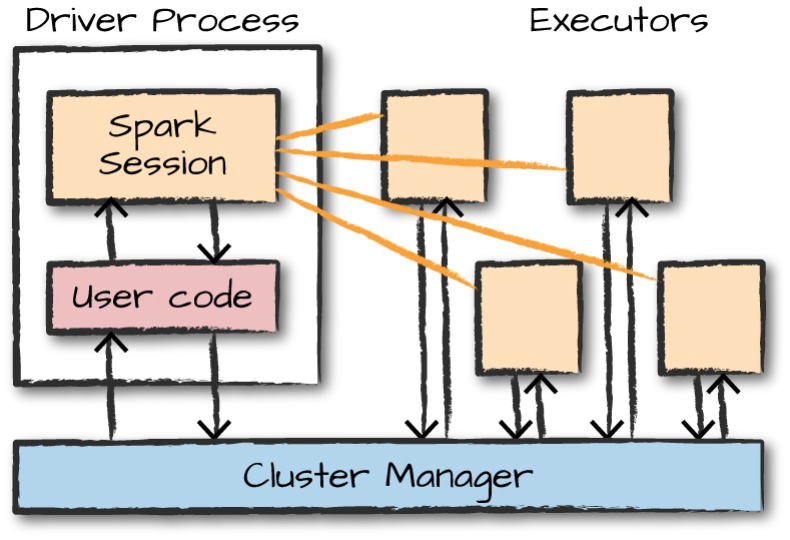

In [1]:
val myRange = spark.range(1000).toDF("number")
myRange.show()

Intitializing Scala interpreter ...

Spark Web UI available at http://IN2302261W2.mshome.net:4040
SparkContext available as 'sc' (version = 2.4.4, master = local[*], app id = local-1585805157772)
SparkSession available as 'spark'


+------+
|number|
+------+
|     0|
|     1|
|     2|
|     3|
|     4|
|     5|
|     6|
|     7|
|     8|
|     9|
|    10|
|    11|
|    12|
|    13|
|    14|
|    15|
|    16|
|    17|
|    18|
|    19|
+------+
only showing top 20 rows



myRange: org.apache.spark.sql.DataFrame = [number: bigint]


## The relationship between the SparkSession and Spark’s Language API
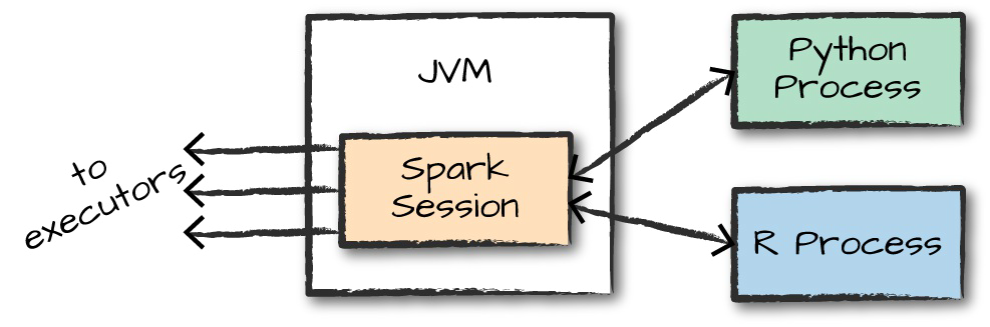

## DataFrames
A DataFrame is the most common Structured API and simply represents a table of data with
rows and columns. The list that defines the columns and the types within those columns is called
the schema. You can think of a DataFrame as a spreadsheet with named columns. 
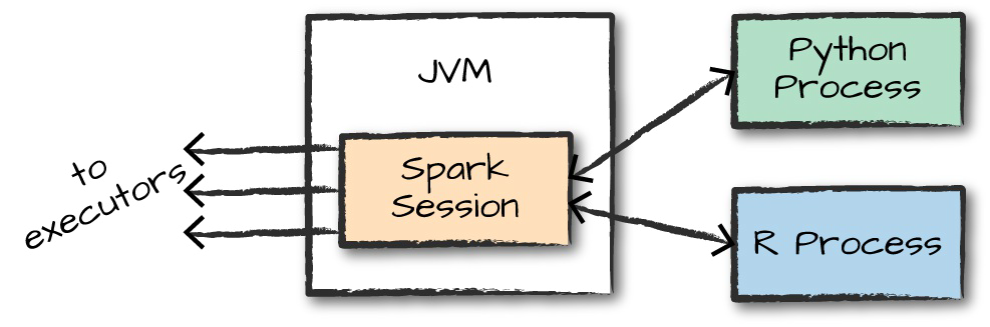

## Partitions
To allow every executor to perform work in parallel, Spark breaks up the data into chunks called
partitions. A partition is a collection of rows that sit on one physical machine in your cluster. A
DataFrame’s partitions represent how the data is physically distributed across the cluster of
machines during execution.

## Transformations
In Spark, the core data structures are immutable, meaning they cannot be changed after they’re
created.To “change” a DataFrame, you need to instruct Spark how you would like to
modify it to do what you want. These instructions are called transformations.

In [6]:
val divisBy2 = myRange.where("number % 2 = 0")
divisBy2.show

+------+
|number|
+------+
|     0|
|     2|
|     4|
|     6|
|     8|
|    10|
|    12|
|    14|
|    16|
|    18|
|    20|
|    22|
|    24|
|    26|
|    28|
|    30|
|    32|
|    34|
|    36|
|    38|
+------+
only showing top 20 rows



divisBy2: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [number: bigint]


Transformations are the core of how you express your business logic using Spark. There are two
types of transformations: 

Transformations consisting of narrow dependencies (we’ll call them narrow transformations) are
those for which each input partition will contribute to only one output partition. In the preceding
code snippet, the where statement specifies a narrow dependency, where only one partition
contributes to at most one output partition
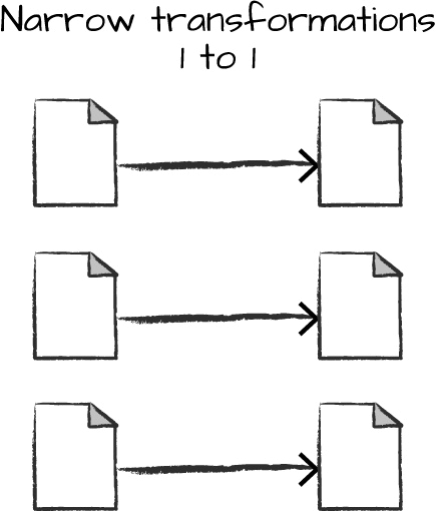

A wide dependency (or wide transformation) style transformation will have input partitions
contributing to many output partitions. You will often hear this referred to as a shuffle whereby
Spark will exchange partitions across the cluster. With narrow transformations, Spark will
automatically perform an operation called pipelining, meaning that if we specify multiple filters
on DataFrames, they’ll all be performed in-memory. The same cannot be said for shuffles. When
we perform a shuffle, Spark writes the results to disk.
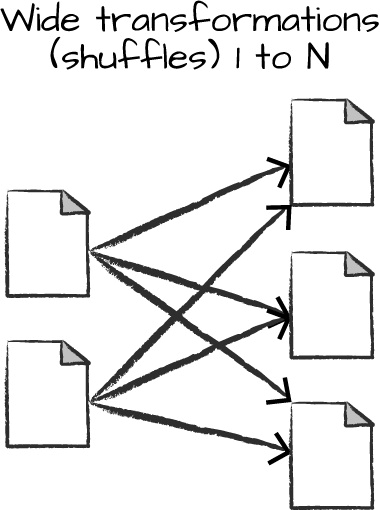

In [3]:
import org.apache.spark.sql.functions._

case class HECursor(id:Int,name:String,fee:Int,vanue:String,duration:Int)
import spark.implicits._
val df = List(HECursor(1001,"Hadoop",6000,"Mumbai",5),
                  HECursor(1002,"Spark",5000,"Bihar",4),
                  HECursor(1003,"Python",4000,"Punjab",3),
                  HECursor(1004,"Scala",9000,"Delhi",6)).toDF
// val rdd = sc.parallelize(objects)
// val df = rdd.toDF
df.show()
val result = df.where('fee>5000)
result.show()
result.explain(true)

+----+------+----+------+--------+
|  id|  name| fee| vanue|duration|
+----+------+----+------+--------+
|1001|Hadoop|6000|Mumbai|       5|
|1002| Spark|5000| Bihar|       4|
|1003|Python|4000|Punjab|       3|
|1004| Scala|9000| Delhi|       6|
+----+------+----+------+--------+

+----+------+----+------+--------+
|  id|  name| fee| vanue|duration|
+----+------+----+------+--------+
|1001|Hadoop|6000|Mumbai|       5|
|1004| Scala|9000| Delhi|       6|
+----+------+----+------+--------+

== Parsed Logical Plan ==
'Filter ('fee > 5000)
+- LocalRelation [id#17, name#18, fee#19, vanue#20, duration#21]

== Analyzed Logical Plan ==
id: int, name: string, fee: int, vanue: string, duration: int
Filter (fee#19 > 5000)
+- LocalRelation [id#17, name#18, fee#19, vanue#20, duration#21]

== Optimized Logical Plan ==
LocalRelation [id#17, name#18, fee#19, vanue#20, duration#21]

== Physical Plan ==
LocalTableScan [id#17, name#18, fee#19, vanue#20, duration#21]


import org.apache.spark.sql.functions._
defined class HECursor
import spark.implicits._
df: org.apache.spark.sql.DataFrame = [id: int, name: string ... 3 more fields]
result: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: int, name: string ... 3 more fields]


## Lazy Evaluation
Lazy evaulation means that Spark will wait until the very last moment to execute the graph of
computation instructions. In Spark, instead of modifying the data immediately when you express
some operation, you build up a plan of transformations that you would like to apply to your
source data. By waiting until the last minute to execute the code, Spark compiles this plan from
your raw DataFrame transformations to a streamlined physical plan that will run as efficiently as
possible across the cluster. 

An example of this is something called **predicate pushdown** on
DataFrames. If we build a large Spark job but specify a filter at the end that only requires us to
fetch one row from our source data, the most efficient way to execute this is to access the single
record that we need. Spark will actually optimize this for us by pushing the filter down
automatically.

## Actions
Transformations allow us to build up our logical transformation plan. To trigger the computation,
we run an action. An action instructs Spark to compute a result from a series of transformations.

In [4]:
divisBy2.count

res3: Long = 500


## Spark UI
The Spark UI is available on port **4040** of the driver node.

## An End-to-End Example

In [9]:
val flightData = spark
  .read
  .option("inferSchema", "true")
  .option("header", "true")
  .csv("data/flight_data.csv")

flightData: org.apache.spark.sql.DataFrame = [DEST_COUNTRY_NAME: string, ORIGIN_COUNTRY_NAME: string ... 1 more field]


In [11]:
flightData.take(3)

res8: Array[org.apache.spark.sql.Row] = Array([United States,Romania,1], [United States,Ireland,264], [United States,India,69])


In [16]:
flightData.sort("count").explain()

== Physical Plan ==
*(2) Sort [count#99 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#99 ASC NULLS FIRST, 200)
   +- *(1) FileScan csv [DEST_COUNTRY_NAME#97,ORIGIN_COUNTRY_NAME#98,count#99] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/Jijo.Sunnygeorge/Documents/personal/self-study/spark_definitive_..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>


In [24]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

flightData2015.sort("count").take(2)

res21: Array[org.apache.spark.sql.Row] = Array([Equatorial Guinea,United States,1], [United States,Romania,1])


## DataFrames and SQL
Spark can run the same transformations, regardless of the language, in the exact same way. You can express your business logic in SQL or DataFrames (either in R, Python, Scala, or Java) and Spark will compile that logic down to an underlying plan (that you can see in the explain plan) before actually executing your code. 

In [25]:
flightData.createOrReplaceTempView("flight_data_2015")

In [28]:
val sqlWay = spark.sql("""
SELECT DEST_COUNTRY_NAME, count(1) as count
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
""")

val dataFrameWay = flightData
  .groupBy('DEST_COUNTRY_NAME)
  .count()

sqlWay.explain
dataFrameWay.explain

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#97, 5)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#97] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/Jijo.Sunnygeorge/Documents/personal/self-study/spark_definitive_..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>
== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#97, 5)
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[partial_count(1)])
      +- *(1) FileScan csv [DEST_COUNTRY_NAME#97] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/Jijo.Sunnygeorge/Documents/personal/self-study/spark_definitive_..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAM

sqlWay: org.apache.spark.sql.DataFrame = [DEST_COUNTRY_NAME: string, count: bigint]
dataFrameWay: org.apache.spark.sql.DataFrame = [DEST_COUNTRY_NAME: string, count: bigint]


In [29]:
spark.sql("SELECT max(count) from flight_data_2015").take(1)

res26: Array[org.apache.spark.sql.Row] = Array([348113])


In [30]:
// in Scala
import org.apache.spark.sql.functions.max

flightData2015.select(max("count")).take(1)

import org.apache.spark.sql.functions.max
res27: Array[org.apache.spark.sql.Row] = Array([348113])


Let’s perform something a bit more
complicated and find the top five destination countries in the data.

In [31]:
val maxSql = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")

maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           384932|
|           Canada|             8271|
|           Mexico|             6200|
|   United Kingdom|             1629|
|          Germany|             1392|
+-----------------+-----------------+



maxSql: org.apache.spark.sql.DataFrame = [DEST_COUNTRY_NAME: string, destination_total: bigint]


Now, let’s move to the DataFrame syntax that is semantically similar but slightly different in
implementation and ordering.

In [35]:
import org.apache.spark.sql.functions.desc

flightData2015
  .groupBy("DEST_COUNTRY_NAME")
  .sum("count")
  .withColumnRenamed("sum(count)", "destination_total")
  .sort(desc("destination_total"))
  .limit(5)
  .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           384932|
|           Canada|             8271|
|           Mexico|             6200|
|   United Kingdom|             1629|
|          Germany|             1392|
+-----------------+-----------------+



import org.apache.spark.sql.functions.desc


Lets look at the explain plan, and we can see the plan is exactly the same

In [36]:
maxSql.explain()
flightData2015
  .groupBy("DEST_COUNTRY_NAME")
  .sum("count")
  .withColumnRenamed("sum(count)", "destination_total")
  .sort(desc("destination_total"))
  .limit(5).explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[aggOrder#319L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#97,destination_total#233L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[sum(cast(count#99 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#97, 5)
      +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#97], functions=[partial_sum(cast(count#99 as bigint))])
         +- *(1) FileScan csv [DEST_COUNTRY_NAME#97,count#99] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/C:/Users/Jijo.Sunnygeorge/Documents/personal/self-study/spark_definitive_..., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>
== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#330L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#81,destination_total#330L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#81], functions=[sum(cast(count#83 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NA

The true execution plan (the one visible in explain) will differ from that shown in Figure 2-10
because of optimizations in the physical execution; however, the llustration is as good of a


starting point as any. This execution plan is a directed acyclic graph (DAG) of transformations,
each resulting in a new immutable DataFrame, on which we call an action to generate a result.
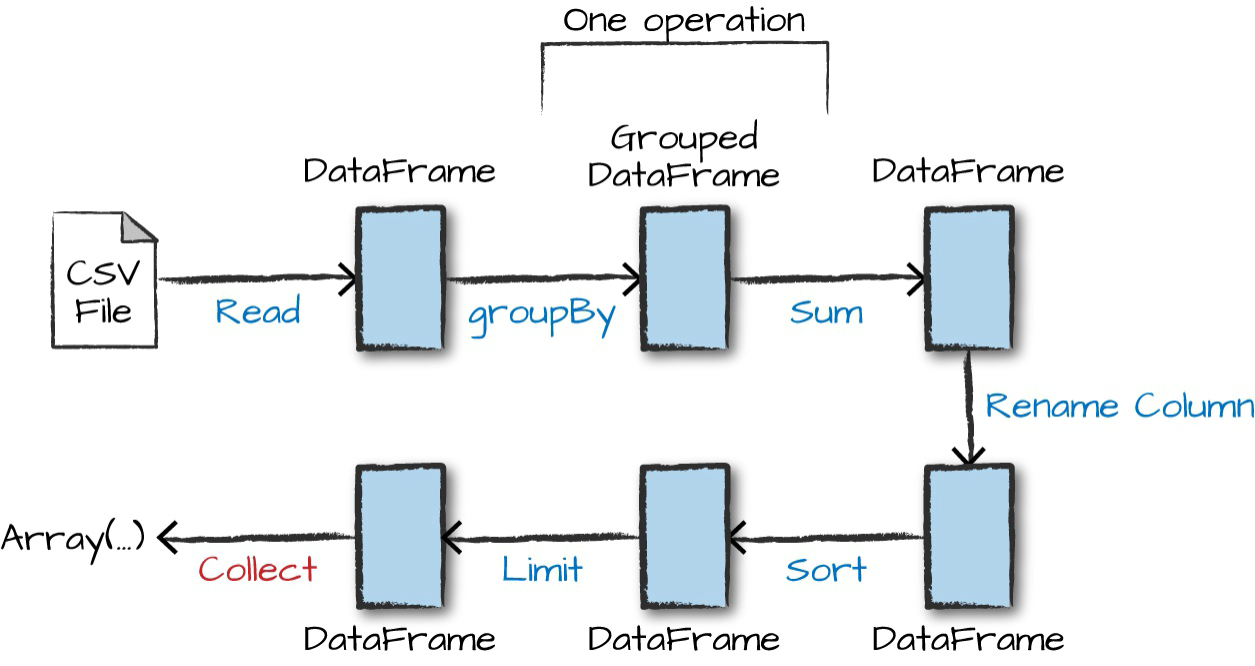